## Imports

In [1]:
include("einsum3.jl")
include("./data_generation.jl")
include("./model.jl")

using MLDatasets
using Images
using StatsBase

import .ClusterTests
import .DataGeneration

## Load data in

In [2]:
train_x, train_y = MLDatasets.MNIST.traindata();
test_x, test_y = MLDatasets.MNIST.testdata();

In [3]:
display(size(train_x))
display(size(test_x))
display(size(train_y))
display(size(test_y))

(28, 28, 60000)

(28, 28, 10000)

(60000,)

(10000,)

## Reduce Dataset to facilitate training for SON

In [4]:
## get all numbers which are either 1 or 8
# For training set
train_x_18 = [train_x[:,:,key] for (key, label) in enumerate(train_y) if label==1 || label==8];
train_y_18 = [train_y[key] for (key, label) in enumerate(train_y) if label==1 || label==8];
# For test set
test_x_18 = [test_x[:,:,key] for (key, label) in enumerate(test_y) if label==1 || label==8];
test_y_18 = [test_y[key] for (key, label) in enumerate(test_y) if label==1 || label==8];

"Feature x:"

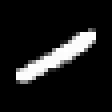

"label y: 1"

In [5]:
## randomly select total_num points
total_num = 100
# we'll sample (without replacement) the index values in order to have consistency between features and labels
# get last number in range 
last_num_train = size(train_x_18)[1]
last_num_test = size(test_x_18)[1]
# perform sampling
train_idx_set = StatsBase.sample(1:last_num_train, total_num, replace=false)
test_idx_set = StatsBase.sample(1:last_num_test, total_num, replace=false)
# extract sampled values (training set)
train_x_18 = [train_x_18[idx] for idx in train_idx_set]
train_y_18 = [train_y_18[idx] for idx in train_idx_set]
# extract sampled values (test set)
test_x_18 = [test_x_18[idx] for idx in test_idx_set]
test_y_18 = [test_y_18[idx] for idx in test_idx_set]

## check to see consistency between feature and label
display("Feature x:")
display(Images.Gray.(train_x_18[57]))
display("label y: $(train_y_18[57])")


In [6]:
## check number of 1's and 8's to make sure there is not a large bias
# number of 1's in train set
ones = count(i->(i==1), train_y_18)
eights = total_num-ones
# number of 1's in test set
ones_test = count(i->(i==1), test_y_18)
eights_test = total_num - ones_test

display("Number of 1's in train set: $ones")
display("Number of 8's in train set: $eights")
display("Number of 1's in test set: $ones_test")
display("Number of 8's in test set: $eights_test")

"Number of 1's in train set: 48"

"Number of 8's in train set: 52"

"Number of 1's in test set: 60"

"Number of 8's in test set: 40"

## Fix numbers to be upright

Currently the numbers are rotated. For the sake of human readability we will rotate them upright

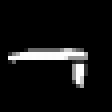

1

In [7]:
display(Images.Gray.(test_x_18[5]))
display(test_y_18[5])

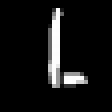

1

In [8]:
## Lets transpose the images to be upright
size_train_x = size(train_x_18)[1]
size_test_x = size(test_x_18)[1]
# Transpose the features for both train and test sets
train_x_18 = [permutedims(train_x_18[i], (2,1)) for i in 1:size_train_x]
test_x_18 = [permutedims(test_x_18[i], (2,1)) for i in 1:size_test_x]
# Lets check the results
display(Images.Gray.(test_x_18[5]))
display(test_y_18[5])

## Convert images to black and white

In [9]:
function black_and_white(nums::Matrix{N0f8}, threshold::Float16)
    """
    Converts grayscale pixel values to either 0 (black) or 1 (white) based on a given threshold.

    :param nums      : Matrix{N0f8};    where each ij entry of said matrix is a grayscale pixel value
    :param threshold : Float16;         hyperparameter in (0, 1) which is the decision boundary of whether pixel value is white or black
    :return          : Matrix{N0f8};    Modified copy of nums where pixel values are adjusted based on "threshold"
    """
    # check threshold in (0,1)
    if (threshold > 1) || (threshold < 0)
        println("Please choose a threshold between (0,1). e.g. threshold = 0.5")
        return
    end
    nums_copy = copy(nums)
    # change pixel values based on threshold
    nums_copy[nums_copy .> threshold] .= N0f8(1.0)
    nums_copy[nums_copy .<= threshold] .= N0f8(0.0)
    return nums_copy
end;

In [11]:
# Convert
train_x_18 = [black_and_white(train_x_18[i], Float16(0.5)) for i in 1:size_train_x]
test_x_18 = [black_and_white(test_x_18[i], Float16(0.5)) for i in 1:size_test_x];

Before:

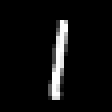

1

In [10]:
# run this before cell above
display(Images.Gray.(train_x_18[8]))
display(train_y_18[8])

After:

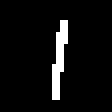

1

In [12]:
display(Images.Gray.(train_x_18[8]))
display(train_y_18[8])

## Padding pattern feature creation

In [13]:
all_patterns_2x2 = Dict{Matrix{N0f8}, Int64}([0.0 0.0; 0.0 0.0]=>0, [1.0 0.0; 0.0 0.0]=>0, [0.0 1.0; 0.0 0.0]=>0, 
                                          [0.0 0.0; 1.0 0.0]=>0, [0.0 0.0; 0.0 1.0]=>0, [1.0 1.0; 0.0 0.0]=>0, 
                                          [0.0 1.0; 1.0 0.0]=>0, [0.0 0.0; 1.0 1.0]=>0, [1.0 0.0; 1.0 0.0]=>0, 
                                          [0.0 1.0; 0.0 1.0]=>0, [1.0 1.0; 1.0 0.0]=>0, [0.0 1.0; 1.0 1.0]=>0, 
                                          [1.0 0.0; 1.0 1.0]=>0, [1.0 1.0; 0.0 1.0]=>0, [1.0 0.0; 0.0 1.0]=>0, 
                                          [1.0 1.0; 1.0 1.0]=>0);

In [15]:
function feature_creation(nums, labels, all_patterns, skip_one=false)
    """
    Converts MNIST pixel features and returns a set of new features based on counts of each pattern
    :param nums         : Vector{Matrix{N0f8}};         original feature set
    :param labels       : Vector{Int64};                original label set
    :param all_patterns : Dict{Matrix{N0f8}, Int64};    keys are patterns based on the size of matrix mask and values being the counts of said patterns (set to 0)
    :param skip_one     : Bool;                         if true: mask matrix skips over 1 column each iterations to avoid overlap, else: shifts by 1 column each iteration
    :return             : Vector{Any};                  new feature matrix based on counts of pixel patterns described in "all_patterns"
    """
    pat_len = length(all_patterns)                  # number of patterns
    N, M = size(nums[1])                            # image dims
    K = length(nums)                                # number of images
    final_feature_matrix = []                       # the feature matrix we return
    if skip_one
        return
    else
        for i in 1:K
            pattern_count = copy(all_patterns)      # refresh pattern count
            curr_num = nums[i]                      # current feature to get patterns from
            curr_label = labels[i]                  # label of current feature
            for j in 0:(N-2)
                for k in 0:(M-2)
                    # perform counts on all available patterns in current number
                    curr_pad = curr_num[1+j:2+j, 1+k:2+k] # extract 2x2 sub-matrix containing pixel pattern
                    pattern_count[curr_pad] += 1          # 
                end
            end
            pattern_count_arr = [v for (k,v) in pattern_count]
            push!(final_feature_matrix, (pattern_count_arr, curr_label))
        end
    end
    return final_feature_matrix
end;

In [16]:
training_set = feature_creation(train_x_18, train_y_18, all_patterns_2x2)
test_set = feature_creation(test_x_18, test_y_18, all_patterns_2x2)
# Lets have a preview of our new training set
display(training_set[1:5])

5-element Vector{Any}:
 ([15, 2, 3, 0, 15, 2, 2, 3, 3, 0, 0, 22, 657, 3, 2, 0], 1)
 ([18, 0, 2, 0, 18, 1, 1, 1, 1, 2, 0, 19, 664, 2, 0, 0], 1)
 ([17, 11, 5, 7, 13, 6, 10, 10, 2, 9, 0, 68, 559, 9, 3, 0], 8)
 ([11, 11, 10, 10, 11, 10, 11, 11, 10, 10, 0, 44, 559, 11, 10, 0], 8)
 ([17, 1, 1, 1, 18, 0, 2, 2, 1, 2, 0, 21, 660, 3, 0, 0], 1)

## Training SON 

In [17]:
train_set_len = length(training_set)
X = [training_set[i][1] for i in 1:train_set_len]
X = hcat(X...) # convert to 16x100 matrix
y = [training_set[i][2] for i in 1:train_set_len];

In [100]:
maxit = 50000
lambda = 0.85
weight = Base.ones(Float64, train_set_len) 
_, _, _, _, _, _, _, _, _, _,  _, clusterID, _, _, _ = ClusterTests.admm_Chi_Lange_wtest(X, lambda, weight, maxit); 

In [101]:
compID = copy(y)
compID[compID.==8] .= 2;

Randind, inda, indb, indc, indd = DataGeneration.compute_randind(compID, clusterID);
display(Randind)

0.01980874316939891

In [103]:
clusterID[clusterID.==0] .= 1
clusterID[clusterID.>1].= 2

Randind, inda, indb, indc, indd = DataGeneration.compute_randind(compID, clusterID);
display(Randind)

0.8883168316831683

seems like it is properly clustering the 1's but fails to cluster the 8's

## Testing using kmeans

In [72]:
using Clustering

R = Clustering.kmeans(X, 2; maxiter=1000, display=:iter)

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.561100e+05


      1       9.154631e+04      -6.456369e+04 |        2
      2       9.146386e+04      -8.245410e+01 |        0
      3       9.146386e+04       0.000000e+00 |        0
K-means converged with 3 iterations (objv = 91463.85547972901)


KmeansResult{Matrix{Float64}, Float64, Int64}([13.471698113207546 11.319148936170214; 4.754716981132075 12.680851063829786; … ; 1.3962264150943395 7.0212765957446805; 0.09433962264150944 0.14893617021276595], [1, 1, 2, 2, 1, 1, 1, 1, 1, 2  …  2, 1, 1, 1, 2, 1, 1, 2, 1, 1], [485.33713065146003, 943.4126023496501, 372.3250339520164, 126.49524671805557, 672.0163759344723, 28.31826272699982, 1915.6390174439875, 589.865432538325, 173.9031683872454, 440.41014033497777  …  221.5590765052475, 252.16731933085248, 1483.865432538325, 518.1295834816992, 602.2399275691714, 600.8843004629016, 913.9409042363986, 199.98460842017084, 1517.2616589533864, 1279.2993948024232], [53, 47], [53, 47], 91463.85547972901, 3, true)

In [83]:
clusterID = assignments(R)
compID = copy(y)
compID[compID.==8] .= 2;

In [86]:
Randind, inda, indb, indc, indd = DataGeneration.compute_randind(compID, clusterID);
display(Randind)

0.905940594059406